# Simple demonstration of using spyIVP independently 

## What is it?
A numerical IVP thingy which lets you define the problem via symbollic elements, using the great python library [sympy](http://www.sympy.org).

In case you want to try and use it more generally, here's some notes and examples.

It's a little bit like Mathematica's NDSolve, but much less functional. NDSolve obviously is way more powerful for solving general equations (including PDEs).  But spyIVP can address a range of useful problems, and has (or will have) a few features that aren't easily reproduced in Mathematica.  Overall it is less of a 'black-box' than NDSolve, for better or worse.

## Some useful features: 
1. Can easily add explicit numerical code ( can in Mathematica too, but more hoops)
2. Can (shortly) integrate with high performance backends like tensorflow, both for increased speed and to enable automatic differentiation.
3. The driving use case is ensembles of similar atoms interacting by long-range electric fields: large ensembles of states with long-range coupling. It's not clear to me that Mathematica can handle these effectively.

However, if you're problem isn't aready well adapted to the type of problem this was designed for, you're probably better off looking elsewhere. 

Other python ODE solving python packages that may be more appropriate for general use:

* https://github.com/neurophysik/jitcode,
* http://bjodah.github.io/pyodesys/latest/index.html

They both seem more powerful, could likely replace this package for even the desired purpose. However I only learned about them after writing this, and I haven't tried them. To my mind it does seem unlikely that they'll be easily extended to large scales or to automatic differentiation of the whole system as is possible with Tensorflow, but I haven't tried.

Further, the Julia package [DifferentialEquations.jl](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwjkxpr_5PryAhVlxTgGHcGmAnwQFnoECAIQAQ&url=https%3A%2F%2Fdiffeq.sciml.ai%2Fstable%2Ftutorials%2Fode_example%2F&usg=AOvVaw1zBaPCy8uzU9t5n26-mIRa)
 has come a _long_ way since I first saw it, and may well make this totally redundant. If you just want to solve DEs and you're familiar with Julia, you should probably go check that out first.

# Examples

Mostly spyIVP was written to enable assembling/solving ensemble systems described by master-equations, in python. That is described in [Solving master equations]. 

But it's fun to solve ODEs more generally, so here's some projectile motion: In particular, this handles an ensemble of interacting projectiles quite easily and efficiently.




### Imports

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from pylab import *
from spylind import spyIVP as so
import sympy as sm;

#from numpy import warnings
#warnings.simplefilter('error', VisibleDeprecationWarning)
sm.init_printing()

Tensorflow not accessible: No module named 'backend_tf'


# Projectile motion

$$\frac{dx}{dt} = vx$$
$$\frac{dy}{dt} = vy$$

$$\frac{dv_x}{dt} = g$$
$$\frac{dv_y}{dt} = 0$$

In [9]:
xS, yS, vxS, vyS = sm.symbols("x, y, v_x, v_y", real=True)
vxS = sm.symbols('v_x', complex=True)
g= -10.0
dy_dtD = {xS:vxS, 
       yS:vyS,
       vxS:0,
       vyS:g }

Tensorflow not accessible: No module named 'backend_tf'


/home/morgan/miniforge3/envs/spylind/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/morgan/miniforge3/envs/spylind/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


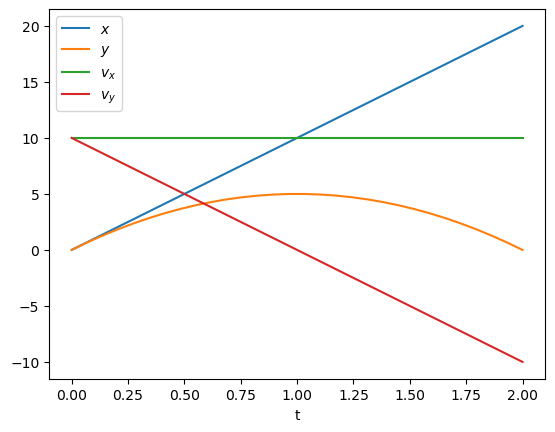

In [10]:
ode_s = so.ODESys(dy_dtD,  trans_dims={}, bDecompose_to_re_im=False)
ode_s.set_initial_state({xS:0,yS:0,vxS:10,vyS:10}) 
model = ode_s.setup_model()
#model = ode_s.setup_model(backend='tensorflow')
tSteps = linspace(0,2,30)
result =model.integrate(tSteps)

#sm.ode
plot(tSteps, result)
xlabel('t')
legend([f'${sym}$'for sym in dy_dtD.keys()])

Check the analytical solution for fun:

In [11]:
tS = sm.symbols("t")
xS = sm.Function('x')(tS)
vxS = sm.Function('v_x')(tS)
yS = sm.Function('y')(tS)
vyS = sm.Function('v_y')(tS)

In [12]:
from sympy.solvers import ode
display(sm.dsolve([sm.Eq(xS.diff(), vxS), sm.Eq(vxS.diff(), 0)])[0])
eqL = [sm.Eq(yS.diff(),vyS), sm.Eq(vyS.diff(), g)]
sm.dsolve(sm.Eq(yS.diff(), g*tS) )

where C_1 and C_2 are both 10 in the above. So check this against the result above:

In [13]:
tEff = tSteps #+ (tSteps[1]-tSteps[0])/2
sym_res = dict(
    x= 10 *tEff,
    y = 10*tEff -5*tEff**2
    )
assert(allclose(result[:,0], sym_res['x']))
assert(allclose(result[:,1], sym_res['y']))

/home/morgan/miniforge3/envs/spylind/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/morgan/miniforge3/envs/spylind/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


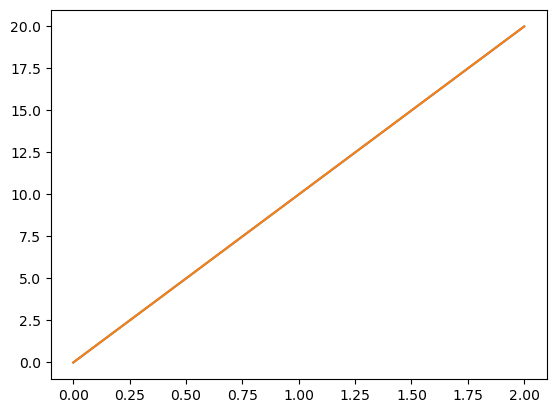

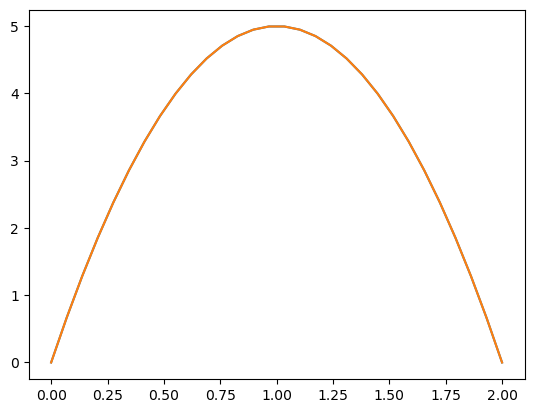

In [14]:
plot(tSteps, result[:,0])
plot(tEff, sym_res['x'])
figure()
plot(tSteps, result[:,1])
plot(tEff, sym_res['y'])

## An ensemble of non-interacting projectiles:

We'll introduce a '$z$' axis. The initial velocity of these projectiles varies along $z$. Further, for some reason the force of gravity is fluctuation, according to some external parameter we'll label $G$. We'll define this numerically, using a 'driving function'. That just means a numerical function that takes $t$ as a parameter and returns the value of that symbol. Here we'll make it sinusoidally varying.

In [15]:
ode_s.set_initial_state??

Signature: ode_s.set_initial_state(par0={}, bRealified=False)
Source:   
    def set_initial_state(self, par0={}, bRealified=False):
        """ Set the initial paramters. The main logic here is to account for different ways they might be expressed.
        Possibilities are:
            * A dictionary of symbol: initial state pairs
            * A list of initial states in the appropriate order
            * An array of initial states, appropriately sized according to all the dimensions
            * The input could be needing to be 'realified' to match the new real-only variables.

        Parameters:
        -----------
        par0: dictionary of {symbol:state} pairs, or an iterable of states (in the right order)
        bRealified: whether it's being specified in the 'realified' format or
            original (potentially) complex format. Relevant only if we're using automatic
            decomposition to real-imaginary parts.
        """
        # Do something to make sure dimens

Text(0.5, 1.0, 'position y vs time and z')

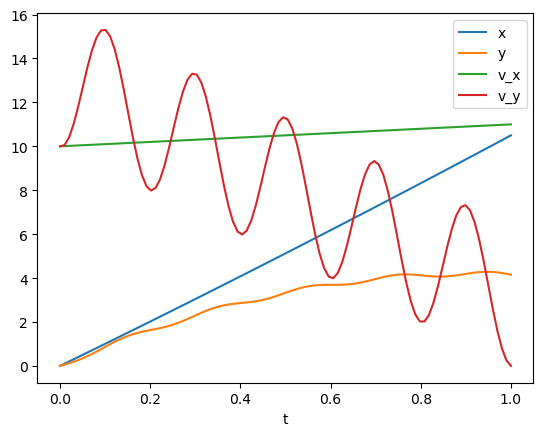

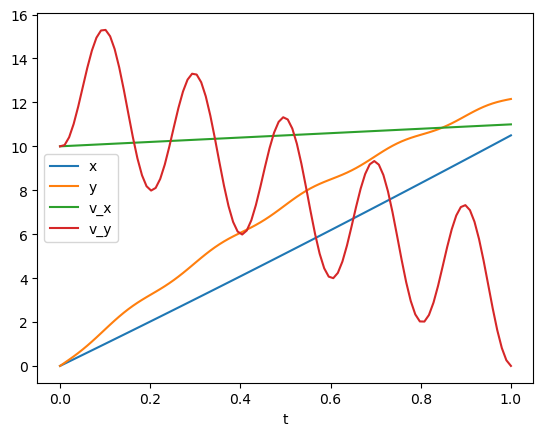

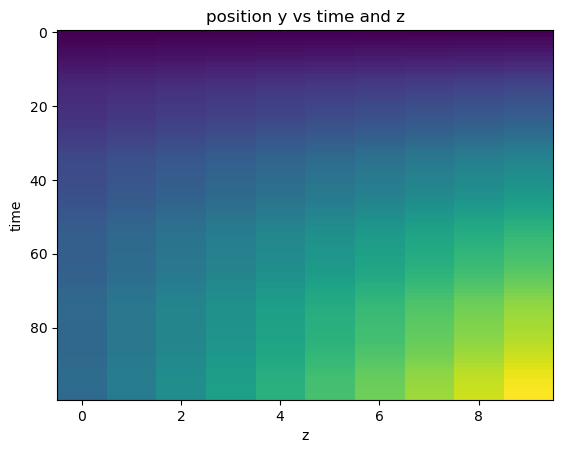

In [16]:
xS, yS, vxS, vyS, GS = sm.symbols("x, y, v_x, v_y, G", real=True)
zS = sm.symbols("z", real=True)
g= -10.0
dy_dtD = {xS:vxS,  # The values are the derivatves of the symbol on the LHS.
       yS:vyS + zS ,
       vxS:1,
       vyS: g  + GS  }

ode_s = so.ODESys(dy_dtD, trans_dims={zS:linspace(-4,4,10)}, driving_syms=[GS],)
ode_s.set_initial_state({xS:0,yS:0,vxS:10,vyS:10}) 
#ode_s.set_driving({GS: lambda t: 100*np.sin(2*pi*5*t)})
t_drv = linspace(0,2,200)
ode_s.set_driving({GS: [t_drv, 100*np.sin(2*pi*5*t_drv)] })

model = ode_s.setup_model(bForceStateDimensions=True)
tSteps = linspace(0,1,100)
arr = model.integrate(tSteps)

plot(tSteps, arr[:,:,0])
xlabel('t')
legend(dy_dtD.keys())
figure()
plot(tSteps, arr[:,:,-1])
xlabel('t')
legend(dy_dtD.keys())
figure()
imshow(arr[:,1,:], aspect='auto')
ylabel('time')
xlabel('z')
title('position y vs time and z')

In [19]:
%debug

> /tmp/ipykernel_129310/3916541060.py(1)<module>()
----> 1 plot(tSteps, result[:,0])
      2 plot(tEff, sym_res['x'])
      3 figure()
      4 plot(tSteps, result[:,1])
      5 plot(tEff, sym_res['y'])



ipdb>  q


## An ensemble of interacting projectiles (via a mutual attraction)

What happens if the projectiles experience a force pushing toward their center-of-mass, proportional to the particles' distance from it?

The interaction is $F_j = \sum_{i\neq j}^n k \frac{y_i-y_j}{|(y_i-y_j)^3|}$. This is infinite as particles get close, which is obviously a problem for a numerical simulation. We'll take the easy option of damping it at close range.

The coupling term is represented by a 'state dependent' python function, which evaluates this numerically.

In principle, we could instead do add symbollic terms into the equations of motion to account for this. One reason not to is that sympy tends not to handle the evaluation of integrals or summations very elegantly- and while this example would probably work ok, others won't. Aside from this, a state-dependent call is often one of the slowest parts of the simulation, and it pays to write it by hand to avoid recalculating parts that don't need recalculation.






In [20]:
xS, yS, vxS, vyS, kS = sm.symbols("x, y, v_x, v_y, k", real=True)
indS = sm.symbols("I", real=True)
g= -10.0
dy_dtD = {xS:vxS, 
       yS:vyS,
       vxS:1,
       vyS: g + 30*kS }

ode_s = so.ODESys(dy_dtD,  trans_dims={indS:arange(10)})
ode_s.summary()


**Function signatures:**

state_dep_f( $\displaystyle t$, dimAxes = $[ \displaystyle I ]$, state = $[ \displaystyle x, \displaystyle y, \displaystyle v_{x}, \displaystyle v_{y} ]$, driving= $[  ]$, intermediate = $[  ]$ )

output_f( $\displaystyle t$, dimAxes = $[ \displaystyle I ]$, state = $[ \displaystyle x, \displaystyle y, \displaystyle v_{x}, \displaystyle v_{y} ]$, driving= $[  ]$, state_dependent= $[  ]$ , intermediate = $[  ]$ )

**Variables:**

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Text(0.5, 1.0, 'mutually attractive projectiles')

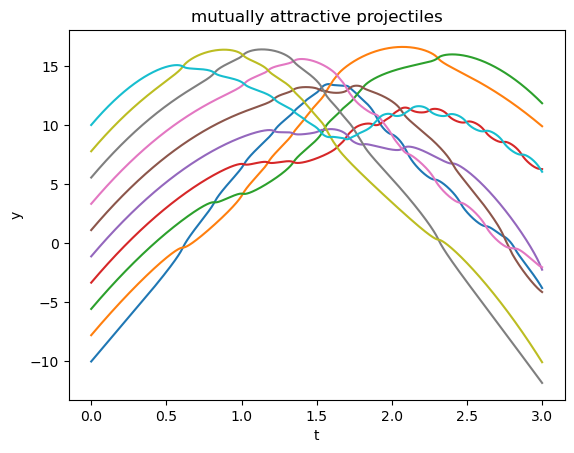

In [21]:

ode_s.set_initial_state({xS:0*ones(10),yS:linspace(-10,10,10),vxS:10*ones(10),vyS:15*ones(10) }) 
def couplingF(t, dimAxes, state, driving_vals, _intermediate, _constants):
    x,y,vx,vy = state
    diff = y[:,newaxis] - y[newaxis,:]
    diff[np.diag_indices_from(diff)]=1e20 # Stop divide by zeros due to distance of particles from themselves
    sq_diff = diff**2 / (1- exp(-(diff/0.3)**2 ))#  The denominator is to damp the interaction for close particles, to avodi it blowing up
    F = -np.sum(sign(diff)/sq_diff, axis=1)
    return F
ode_s.set_state_dependence({kS:couplingF})

model = ode_s.setup_model(bForceStateDimensions=True)
tSteps = linspace(0,3.,2000)
arr = model.integrate(tSteps)

plot(tSteps, arr[:,1,:].real)
xlabel('t')
ylabel('y')
title("mutually attractive projectiles")


## Using a custom output function
By default, we store the whole state at every time step. This can eat up a lot of memory however, and often times we only care about a single parameter. So we can also add a function to evaluate at every step, the result of which will be saved instead of the full state.

Below we'll repeat the simulation above, but this time only saving the particle mean position.

CPU times: user 582 ms, sys: 22.2 ms, total: 604 ms
Wall time: 581 ms


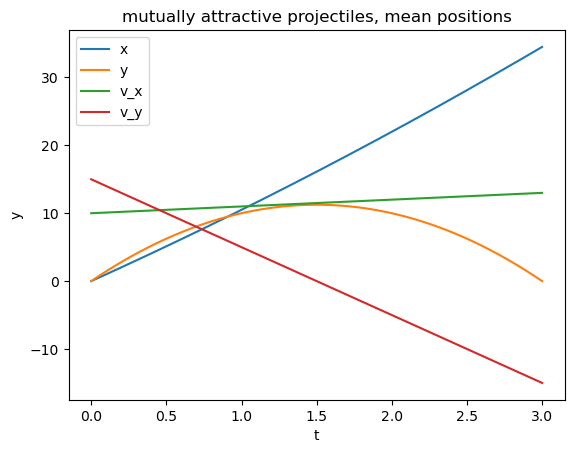

In [29]:
def output_mean_state(t, state, *args):
    mean_state = state.mean(axis=1)
    return mean_state
ode_s.set_outputs(output_mean_state)


model = ode_s.setup_model(bForceStateDimensions=True)
%time arr =model.integrate(tSteps)

plot(tSteps, arr[:,:])
xlabel('t')
ylabel('y')
title("mutually attractive projectiles, mean positions")
legend(ode_s.symsD.state)

